#**Predicting Flight Delays for Chicago O'Hare International Airport**


---



---



Created by: Sucheta Das, Riddhima Shukla, Ojus Sindwani, Ishan Nagrani

***

## **Table Of Contents:** 

1.[Problem Statement](#1)

2.[Exploratory Data Analysis](#2)

3.[Final Pipeline](#3)

4.[Splitting the data](#4)

5.[Classification Models](#5)

6.[Model Evaluation](#6)

7.[Plotting the Models](#7)

8.[Hyper-parameter Tuning](#8)

9.[Cost of predicting non-delays as delays](#9)

10.[Voting](#10)

11.[Boosting](#11)

12.[Model Scores](#12)

13.[Feature Selection](#13)

14.[Using XGB Classifier on Test set](#14)

15.[Conclusion](#15)

<a id="1"></a>

##[Problem Statement](#1)




The project aims to predict whether a flight at the Chicago O'Hare International Airport will get delayed for more than 15 minutes based on the following variables:
* Airport (Previous airport and Departing Airport)
* Weather details of the Departing Airport
* Airport & Airline Operations
* Time, Day, and Month of departure

We are choosing only the said airport for our model as the airport is notoriously known for it's delays and lack of resources for airport operations. We believe with our model it could be possible to predict whether a flight that is departing from or arriving to the Chicago O'Hare International Airport will get delayed by 15 minutes or not. Our objective is to build a classification model that can reduce the prediction errors for predicting the flight delays and also the cost of predicting non delays when delays are actually happening. 

In [ ]:
# importing preprocessors
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.model_selection import cross_validate
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score, make_scorer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('seaborn-white')

In [ ]:
# mounting drive 
from google.colab import drive
drive.mount('/content/drive')
data_folder = '/content/drive/Shareddrives/BA810/'

Mounted at /content/drive


Early on in the analysis we found that our raw dataset is too large to work with on a Google Colab notebook. It would be convenient to run a much smaller dataset which is why we decided to subset our data and focus on just improving the Chicago O'Hare International Airport operations.

In [ ]:
df = pd.read_csv(data_folder+'full_data_flightdelay.csv')
df = df[df['DEPARTING_AIRPORT']=="Chicago O'Hare International"]

<a id="2"></a>

##[Exploratory Data Analysis](#2)

### Summary Statistics

In [ ]:
df.shape # 329,045 rows and 26 columns

(329045, 26)

In [ ]:
pd.set_option('display.max_columns', None)
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,MONTH,DAY_OF_WEEK,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND
count,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00,329045.00
mean,6.67,3.94,0.23,3.42,3.13,56.94,117.29,27609.80,51439.14,4803.79,3103410.00,5903273.01,0.00,0.00,11.59,41.98,-87.91,0.13,0.08,0.32,59.32,9.51
std,3.36,1.99,0.42,1.93,1.71,15.22,52.92,2188.38,22843.06,1972.68,0.00,4262742.77,0.00,0.00,6.51,0.00,0.00,0.31,0.44,1.26,21.03,3.38
min,1.00,1.00,0.00,1.00,1.00,1.00,44.00,22752.00,8643.00,10.00,3103410.00,473794.00,0.00,0.00,0.00,41.98,-87.91,0.00,0.00,0.00,-10.00,2.91
25%,4.00,2.00,0.00,2.00,2.00,47.00,66.00,26830.00,27159.00,4795.00,3103410.00,1529740.00,0.00,0.00,5.00,41.98,-87.91,0.00,0.00,0.00,42.00,7.16
50%,7.00,4.00,0.00,3.00,3.00,58.00,124.00,28583.00,53980.00,5410.00,3103410.00,3472966.00,0.00,0.00,13.00,41.98,-87.91,0.00,0.00,0.00,61.00,9.17
75%,10.00,6.00,0.00,4.00,4.00,68.00,160.00,29376.00,72721.00,5992.00,3103410.00,8501631.00,0.00,0.00,17.00,41.98,-87.91,0.08,0.00,0.00,78.00,11.63
max,12.00,7.00,1.00,11.00,10.00,92.00,337.00,29971.00,91062.00,7167.00,3103410.00,12460183.00,0.00,0.00,32.00,41.98,-87.91,2.28,5.40,9.80,95.00,25.95


In [ ]:
df = df.drop(['DEPARTING_AIRPORT', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH',
             'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT', 'AVG_MONTHLY_PASS_AIRLINE', 'LATITUDE', 'LONGITUDE'], axis=1)

Since the original dataset contains information on all the domestic airports across the United States, columns irrelevant to the Chicago O'Hare International Airport have to be dropped. Therefore, the columns departing airport, airport flights month, airline flights month, the airline airport flights month, avg monthly pass airport, longitude, and latitude have been dropped. 

In [ ]:
df.isna().sum()

MONTH                      0
DAY_OF_WEEK                0
DEP_DEL15                  0
DEP_TIME_BLK               0
DISTANCE_GROUP             0
SEGMENT_NUMBER             0
CONCURRENT_FLIGHTS         0
NUMBER_OF_SEATS            0
CARRIER_NAME               0
FLT_ATTENDANTS_PER_PASS    0
GROUND_SERV_PER_PASS       0
PLANE_AGE                  0
PREVIOUS_AIRPORT           0
PRCP                       0
SNOW                       0
SNWD                       0
TMAX                       0
AWND                       0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329045 entries, 1541 to 6448907
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   MONTH                    329045 non-null  int64  
 1   DAY_OF_WEEK              329045 non-null  int64  
 2   DEP_DEL15                329045 non-null  int64  
 3   DEP_TIME_BLK             329045 non-null  object 
 4   DISTANCE_GROUP           329045 non-null  int64  
 5   SEGMENT_NUMBER           329045 non-null  int64  
 6   CONCURRENT_FLIGHTS       329045 non-null  int64  
 7   NUMBER_OF_SEATS          329045 non-null  int64  
 8   CARRIER_NAME             329045 non-null  object 
 9   FLT_ATTENDANTS_PER_PASS  329045 non-null  float64
 10  GROUND_SERV_PER_PASS     329045 non-null  float64
 11  PLANE_AGE                329045 non-null  int64  
 12  PREVIOUS_AIRPORT         329045 non-null  object 
 13  PRCP                     329045 non-null  float64
 14  

In [ ]:
pd.set_option('display.max_columns', None)
test = df[(df['DAY_OF_WEEK']==1) & (df['MONTH']==1) & (df['CARRIER_NAME']== 'Southwest Airlines Co.')]
test.to_csv(r'/content/drive/Shareddrives/BA810/Test.csv')

In [ ]:
df.nunique()

MONTH                       12
DAY_OF_WEEK                  7
DEP_DEL15                    2
DEP_TIME_BLK                19
DISTANCE_GROUP              10
SEGMENT_NUMBER              10
CONCURRENT_FLIGHTS          92
NUMBER_OF_SEATS             61
CARRIER_NAME                13
FLT_ATTENDANTS_PER_PASS     11
GROUND_SERV_PER_PASS        13
PLANE_AGE                   33
PREVIOUS_AIRPORT           231
PRCP                        67
SNOW                        23
SNWD                        10
TMAX                        85
AWND                        69
dtype: int64

## Questions

#### 1. What are the percentage delays of domestic flights per month in 2019 departing from the Chicago O'Hare Airport?

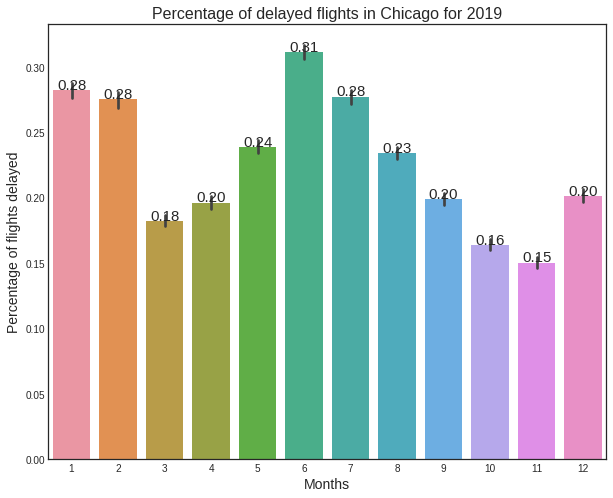

In [ ]:
plt.figure(figsize=(10, 8))
plots = sns.barplot(x='MONTH', y='DEP_DEL15', data=df)

# Iterrating over the bars one-by-one
for bar in plots.patches:

    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 5),
                   textcoords='offset points')
 
# Setting the label for x-axis
plt.xlabel("Months", size=14)
 
# Setting the label for y-axis
plt.ylabel("Percentage of flights delayed", size=14)
 
# Setting the title for the graph
plt.title("Percentage of delayed flights in Chicago for 2019", size=16)
 
# Finally showing the plot
plt.show()

The figure above shows the percentage of flights delayed per month. With a value of over 25, the summer months of June and July and winter months of January and February have the highest percentage of flight delays. From our research we found that the overal flights in the USA do get delayed most in these months and this is extreme in the Chicago O'Hare International Airport.

#### 2. What are the correlations between the variables in the dataset? 

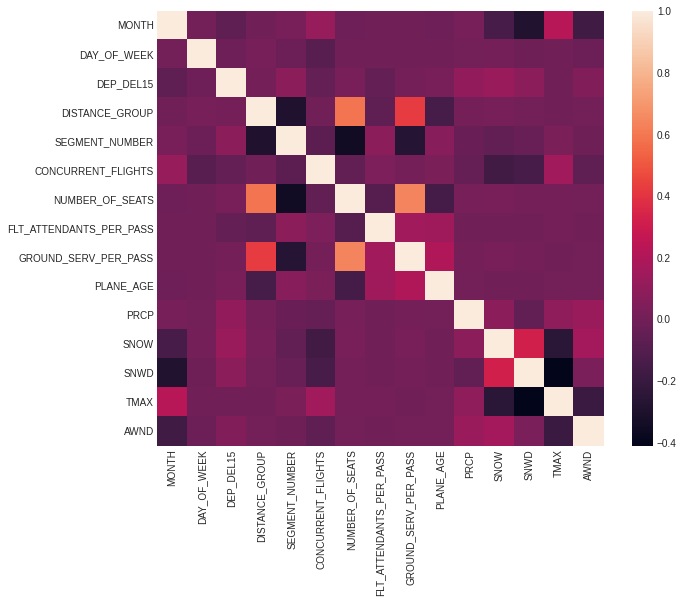

In [ ]:
#correlation matrix for the whole dataset
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr)

In terms of dep_del15 (delays of 15 minutes or more), the weather variables of PRCP, SNOW, SNWD, TMAX, and AWND are the most correlated. Furthermore, as the distance group increases, the number of seats on the aircraft as well as ratio of groudstaff per passenger increases, showing a positive linear correlation.

In [ ]:
#numerical display of the corelation matrix
pd.set_option('display.max_columns', None)
corr

,MONTH,DAY_OF_WEEK,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,PRCP,SNOW,SNWD,TMAX,AWND
MONTH,1.000000,0.005084,-0.060784,-0.003641,0.021493,0.121493,-0.010406,-0.004175,-0.001628,-0.011107,0.014961,-0.141316,-0.286363,0.226527,-0.171122
DAY_OF_WEEK,0.005084,1.000000,-0.012239,0.014965,-0.022991,-0.086578,0.002124,-0.006523,-0.003392,-0.004791,0.008044,0.011765,-0.016856,-0.005265,-0.021968
DEP_DEL15,-0.060784,-0.012239,1.000000,0.009807,0.081480,-0.046513,0.022091,-0.041575,0.012074,0.020331,0.105198,0.129512,0.085681,0.001967,0.050366
DISTANCE_GROUP,-0.003641,0.014965,0.009807,1.000000,-0.290592,0.002358,0.591780,-0.062714,0.423456,-0.148052,0.008480,0.019159,0.007803,-0.002656,0.003536
SEGMENT_NUMBER,0.021493,-0.022991,0.081480,-0.290592,1.000000,-0.071968,-0.348711,0.082447,-0.272291,0.070052,-0.027153,-0.056343,-0.034940,0.031028,-0.017513
CONCURRENT_FLIGHTS,0.121493,-0.086578,-0.046513,0.002358,-0.071968,1.000000,-0.054400,0.040220,0.009920,0.032785,-0.040446,-0.168167,-0.142193,0.156684,-0.060270
NUMBER_OF_SEATS,-0.010406,0.002124,0.022091,0.591780,-0.348711,-0.054400,1.000000,-0.095643,0.638825,-0.152951,0.013821,0.021482,0.010310,0.009043,0.004473
FLT_ATTENDANTS_PER_PASS,-0.004175,-0.006523,-0.041575,-0.062714,0.082447,0.040220,-0.095643,1.000000,0.155753,0.143991,0.001920,-0.002926,-0.005987,0.010787,-0.000845
GROUND_SERV_PER_PASS,-0.001628,-0.003392,0.012074,0.423456,-0.272291,0.009920,0.638825,0.155753,1.000000,0.196073,0.012748,0.020679,0.009117,-0.003565,0.007582
PLANE_AGE,-0.011107,-0.004791,0.020331,-0.148052,0.070052,0.032785,-0.152951,0.143991,0.196073,1.000000,0.004361,0.000034,-0.003423,0.005742,0.003989


#### 4. Which are the airlines with the most domestic flights departing out of the chicago international airport?

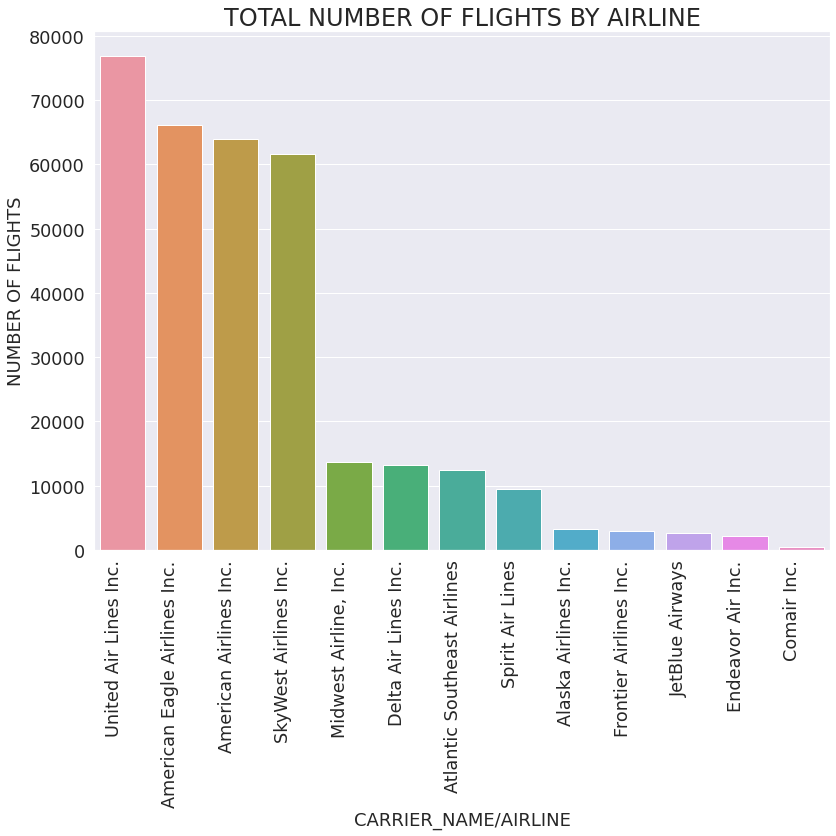

In [ ]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.6)
axis = sns.countplot(x=df['CARRIER_NAME'], data=df, order=df['CARRIER_NAME'].value_counts().iloc[0:18].index, orient="v")
axis.set_xticklabels(axis.get_xticklabels(), rotation=90, ha='right')
plt.title('TOTAL NUMBER OF FLIGHTS BY AIRLINE', fontsize=24)
plt.xlabel('CARRIER_NAME/AIRLINE', fontsize=18)
plt.ylabel('NUMBER OF FLIGHTS', fontsize=18)
plt.tight_layout()
plt.show()

United Airlines operates the highest number of Domestic Flights (76,855) departing from the Chicago O'Hare International Airport. It is followed by American Eagle Airlines and American Airlines. 

#### 5. What are the total number of domestic flight delays per airline for the Chicago Airport for the year 2019?

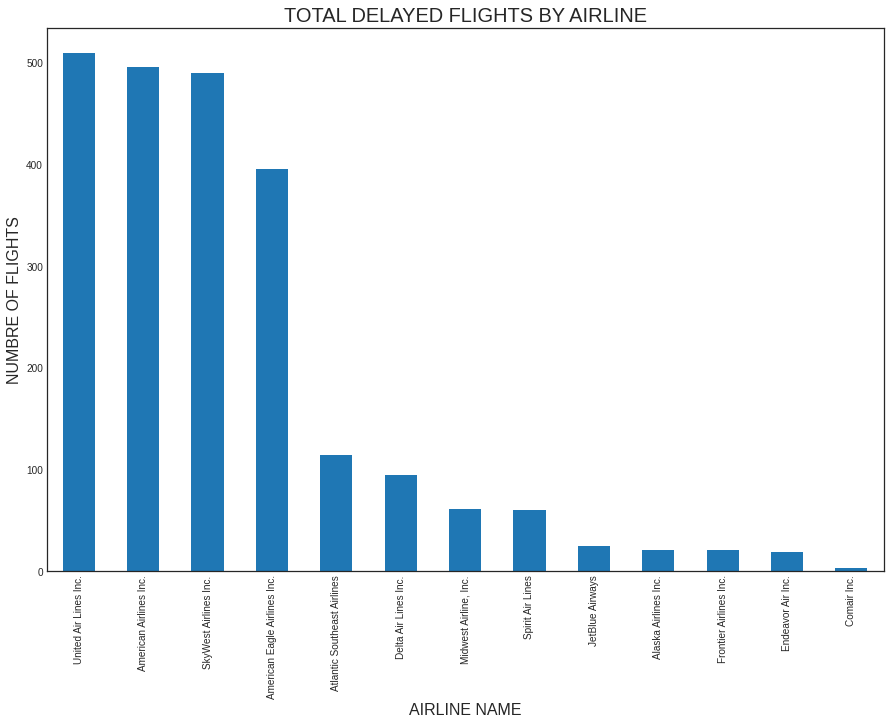

In [ ]:
plt.figure(figsize=(15, 10))
df['DEP_DEL15_1'] = df.DEP_DEL15 == 1
df.groupby('CARRIER_NAME').DEP_DEL15_1.sum().sort_values(ascending=False).plot.bar()
plt.title('TOTAL DELAYED FLIGHTS BY AIRLINE', fontsize=20)
plt.xlabel('AIRLINE NAME', fontsize=16)
plt.ylabel('NUMBRE OF FLIGHTS', fontsize=16)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.show()

United Airlines operates the maximum number of flights departing from Chicago Airport, and also has the maximum number of delayed flights. 
On the other hand, American Eagle Airlines, which operates the second highest maximum flights, has a much lower number of flight delays. 

<a name="6"></a>
##[Sampling and Splitting the Data](#6)

We will further narrow our dataset and take a random sample of 10,000 trips to work with from Chicago O'hare Airport. The reason we are doing is for simplicity sake and to run our machine learning models. In the future, we can scale up to the original dataset. We will then split the dataset with a standard 80-20 train-test split. Our main objective to take this decision is to make the best model possible with our current dataset. However, for future implication we do want to run the model on a much bigger dataset and scale it further. This could give us a better prediction score with feature selection and regularization of the model. 

In [ ]:
df = pd.DataFrame(df)
df = df.sample(n = 10000)
df.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
5960710,12,5,0,1100-1159,1,5,53,50,SkyWest Airlines Inc.,27188,...,16,Chicago O'Hare International,41.978,-87.906,Raleigh-Durham International,0.0,0.0,0.0,41.0,5.59
1197537,3,4,0,1400-1459,3,3,60,129,Atlantic Southeast Airlines,27137,...,11,Chicago O'Hare International,41.978,-87.906,Rochester Monroe County,0.0,0.0,0.0,65.0,12.08
1161766,3,5,0,1500-1559,7,3,62,173,United Air Lines Inc.,27137,...,6,Chicago O'Hare International,41.978,-87.906,Stapleton International,0.0,0.1,0.0,39.0,5.37
5015796,10,5,0,2100-2159,7,5,42,178,Spirit Air Lines,29960,...,4,Chicago O'Hare International,41.978,-87.906,Louis Armstrong New Orleans International,0.0,0.0,0.0,58.0,10.96
2064245,5,5,0,1300-1359,2,4,54,50,American Eagle Airlines Inc.,28802,...,14,Chicago O'Hare International,41.978,-87.906,Central Wisconsin,0.0,0.0,0.0,81.0,9.40


In [ ]:
X = df.drop("DEP_DEL15", axis=1)
y = df["DEP_DEL15"]

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = .2, random_state=0)

<a name="3"></a>

##[Final Pipeline](#3)

Now let's build a pipeline to preprocess the numerical attributes using standardcalar() and categorical attributes using onehotencoder(). We use SimpleImputer() to scale it to any dataset that might contain null values in the future production stage. 

In [ ]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False, drop="first"))
    ])

In [ ]:
from sklearn import set_config
set_config(display='diagram')

num_attribs = ["NUMBER_OF_SEATS", "PLANE_AGE", "PRCP",	"SNOW",	"SNWD",	"TMAX",	"AWND", "FLT_ATTENDANTS_PER_PASS", "GROUND_SERV_PER_PASS"]
cat_attribs = ["DEP_TIME_BLK", "DAY_OF_WEEK", "DISTANCE_GROUP", "SEGMENT_NUMBER", "MONTH"]
SimpleImputer.get_feature_names_out = StandardScaler.get_feature_names_out

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

preprocess_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['NUMBER_OF_SEATS', 'PLANE_AGE', 'PRCP',
                                  'SNOW', 'SNWD', 'TMAX', 'AWND',
                                  'FLT_ATTENDANTS_PER_PASS',
                                  'GROUND_SERV_PER_PASS']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 ['DEP_TIME_BLK', 'DAY_OF_WEEK',
                                  'DISTANCE_GROUP', 'SEGMENT_NUMBER',
                                  'MONTH'])])

In [ ]:
full_pipeline_xgb = make_pipeline(preprocess_pipeline, XGBClassifier(n_estimators=100, random_state=42))

full_pipeline_xgb

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NUMBER_OF_SEATS',
                                                   'PLANE_AGE', 'PRCP', 'SNOW',
                                                   'SNWD', 'TMAX', 'AWND',
                                                   'FLT_ATTENDANTS_PER_PASS',
                                                   'GROUND_SERV_PER_PASS']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['DEP_TIME_BLK',
                                                   'DAY_OF_WEEK',
                                                   'DISTANCE_GROUP',
                                                   'SEGMENT_NUMBER',
                                                   'MONTH'])])),
                ('xgbclassifier', XGBClassifier(random_state=42))])

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_X, train_y)
y_train = train_y
#preprocess_pipeline.get_feature_names_out()

In [ ]:
X_test = preprocess_pipeline.transform(test_X)
y_test = test_y

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 62), (2000, 62), (8000,), (2000,))

<a name="5"></a>

##[Classification Models](#5)

For our first model we will look at XGBoost Classifier, that uses decision trees as learners.

### XGBClassifier 

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train 
)

In [ ]:
xgb = XGBClassifier(n_estimators=100, random_state=0, max_depth=60, n_jobs=3, learning_rate=0.5)
xgb.fit(X_train, y_train, sample_weight=sample_weights)
#xgb.get_params()  

XGBClassifier(learning_rate=0.5, max_depth=60, n_jobs=3)

In [ ]:
y_pred = xgb.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.75

In [ ]:
balanced_accuracy_score(y_test, y_pred)

0.5864956474514939

In [ ]:
#confusion matrix for xgb
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1370  183]
 [ 317  130]]


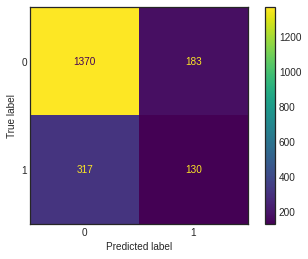

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [ ]:
#classification report for xgb
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      1553
           1       0.42      0.29      0.34       447

    accuracy                           0.75      2000
   macro avg       0.61      0.59      0.59      2000
weighted avg       0.72      0.75      0.73      2000



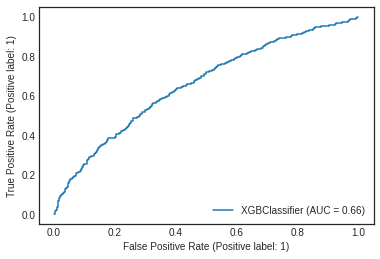

In [ ]:
# ROC for xgb
RocCurveDisplay.from_estimator(xgb, X_test, y_test);

In [ ]:
print('r2_score: ', r2_score(y_test, y_pred))

r2_score:  -0.44052573427197994


In [ ]:
xgb_pipe = make_pipeline(preprocess_pipeline, XGBClassifier(n_estimators=100, random_state=42, max_depth=60, n_jobs=3, learning_rate=0.5))
xgb_pipe = Pipeline([
        ("imputer", preprocess_pipeline),
        ("xgb_classifier", XGBClassifier(n_estimators=100, random_state=42, max_depth=60, n_jobs=3, learning_rate=0.5))
    ])
xgb_scores = cross_val_score(xgb_pipe, X, y, cv=10, scoring='balanced_accuracy')
xgb_scores.mean().round(2)

0.59

### Logistic Regression

For our second machine learning model we will look at logistic regression and fit a regression curve for our caetgorical variable flight delays.

In [ ]:
full_pipeline_lr = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('LogisticRegression', LogisticRegression()),
])

full_pipeline_lr

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NUMBER_OF_SEATS',
                                                   'PLANE_AGE', 'PRCP', 'SNOW',
                                                   'SNWD', 'TMAX', 'AWND',
                                                   'FLT_ATTENDANTS_PER_PASS',
                                                   'GROUND_SERV_PER_PASS']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['DEP_TIME_BLK',
                                                   'DAY_OF_WEEK',
                                                   'DISTANCE_GROUP',
                                                   'SEGMENT_NUMBER',
                                                   'MONTH'])])),
                ('LogisticRegression', LogisticRegression())])

In [ ]:
lr = LogisticRegression(max_iter=200, random_state=42)
lr.fit(X_train, y_train)
#lr.get_params()

LogisticRegression(max_iter=200, random_state=42)

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.7825

In [ ]:
balanced_accuracy_score(y_test, y_pred)

0.5277618119508896

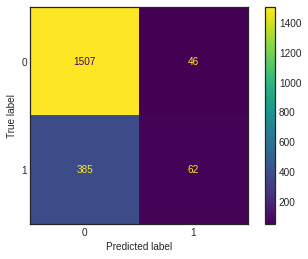

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [ ]:
#classification report for xgb
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.87      1553
           1       0.57      0.14      0.22       447

    accuracy                           0.78      2000
   macro avg       0.69      0.55      0.55      2000
weighted avg       0.75      0.78      0.73      2000



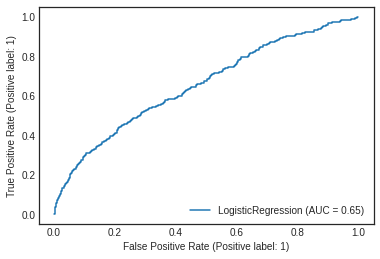

In [ ]:
# ROC for xgb
RocCurveDisplay.from_estimator(lr, X_test, y_test);

In [ ]:
print('r2_score: ', r2_score(y_test, y_pred))

r2_score:  -0.24173318294244672


In [ ]:
lr_pipe = make_pipeline(preprocess_pipeline, LogisticRegression(max_iter=200, random_state=42))
lr_scores = cross_val_score(lr_pipe, X, y, cv=10, scoring='balanced_accuracy')
lr_scores.mean().round(2)

0.53

### SVM

For our third Machine Learning model we will look at SVM(Support Vector Machines). SVM is basically a linear model for our classification problem that will create a line/hyperplane which seperates the data into the classes.
The support vector machine determines the best way to classify data based on its position relative to a border between positive and negative classes. Area between these margins is called the hyperplane , which maximize the distance between data points from different our two different classes (0- nondelays and 1-delays).

In [ ]:
full_pipeline_svm = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('SVM', SVC()),
])

full_pipeline_lr

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NUMBER_OF_SEATS',
                                                   'PLANE_AGE', 'PRCP', 'SNOW',
                                                   'SNWD', 'TMAX', 'AWND',
                                                   'FLT_ATTENDANTS_PER_PASS',
                                                   'GROUND_SERV_PER_PASS']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['DEP_TIME_BLK',
                                                   'DAY_OF_WEEK',
                                                   'DISTANCE_GROUP',
                                                   'SEGMENT_NUMBER',
                                                   'MONTH'])])),
                ('LogisticRegression', LogisticRegression())])

In [ ]:
from sklearn.svm import SVC

lin_svc = SVC(C=1, kernel='poly', degree=1) 
lin_svc.fit(X_train, y_train)

print(lin_svc.n_support_) 

# print(lin_svc.support_vectors_)

[2496 1857]


In [ ]:
accuracy_score(y_test, y_pred)

0.7725

In [ ]:
balanced_accuracy_score(y_test, y_pred)

0.5229158833807986

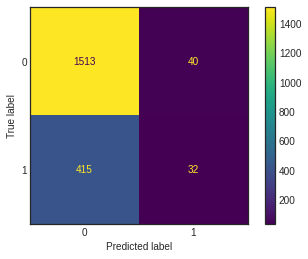

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.97      0.87      1553
           1       0.44      0.07      0.12       447

    accuracy                           0.77      2000
   macro avg       0.61      0.52      0.50      2000
weighted avg       0.71      0.77      0.70      2000



In [ ]:
svc_pipe = make_pipeline(preprocess_pipeline, SVC(gamma="auto"))
svc_scores = cross_val_score(svc_pipe, X, y, cv=10, scoring='balanced_accuracy')
svc_scores.mean().round(2)

0.51

### KNN

For our fourth machine learning model, we will look at KNN (K-nearest neighbours). KNN will classify the points that are more similar to it and predict flight delays depending on the classifications.

In [ ]:
full_pipeline_knn = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('KNN', KNeighborsClassifier(n_neighbors=10)),
])

full_pipeline_lr

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NUMBER_OF_SEATS',
                                                   'PLANE_AGE', 'PRCP', 'SNOW',
                                                   'SNWD', 'TMAX', 'AWND',
                                                   'FLT_ATTENDANTS_PER_PASS',
                                                   'GROUND_SERV_PER_PASS']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['DEP_TIME_BLK',
                                                   'DAY_OF_WEEK',
                                                   'DISTANCE_GROUP',
                                                   'SEGMENT_NUMBER',
                                                   'MONTH'])])),
                ('LogisticRegression', LogisticRegression())])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#knn.get_params()

In [ ]:
accuracy_score(y_test, y_pred)

0.7725

In [ ]:
balanced_accuracy_score(y_test, y_pred)

0.5229158833807986

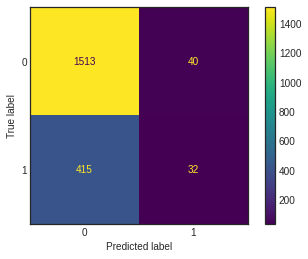

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.97      0.87      1553
           1       0.44      0.07      0.12       447

    accuracy                           0.77      2000
   macro avg       0.61      0.52      0.50      2000
weighted avg       0.71      0.77      0.70      2000



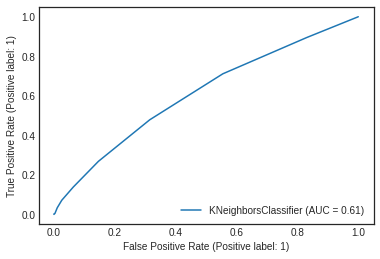

In [ ]:
RocCurveDisplay.from_estimator(knn, X_test, y_test);

In [ ]:
knn_pipe = make_pipeline(preprocess_pipeline, KNeighborsClassifier())
knn_scores = cross_val_score(knn_pipe, X, y, cv=10, scoring='balanced_accuracy')
knn_scores.mean().round(2)

0.55

###Random Forest

For our last and fifth machine learning model, we will look at Random Forest. In our case, it is an ensemble learning method for classification, that operates by constructing a multitude of decision trees at training time.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 50, min_samples_leaf = 3, n_jobs = 3)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=3, n_jobs=3,
                       random_state=42)

In [ ]:
y_pred = forest_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.785

In [ ]:
balanced_accuracy_score(y_test, y_pred).round(4)

0.5405

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1526   27]
 [ 403   44]]


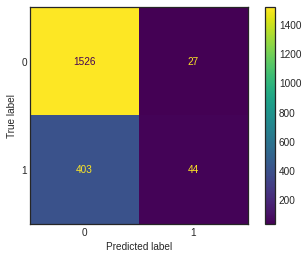

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [ ]:
#classification report for random forest
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      1553
           1       0.62      0.10      0.17       447

    accuracy                           0.79      2000
   macro avg       0.71      0.54      0.52      2000
weighted avg       0.75      0.79      0.72      2000



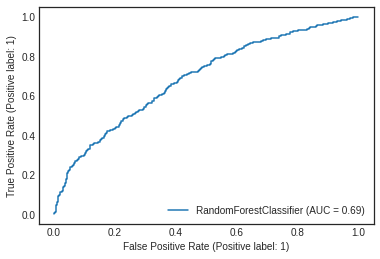

In [ ]:
# ROC for random forest
RocCurveDisplay.from_estimator(forest_clf, X_test, y_test);

In [ ]:
#full pipeline
rf_pipe = make_pipeline(preprocess_pipeline, RandomForestClassifier(n_estimators=100, random_state=42, max_depth=40, min_samples_leaf=5, n_jobs=5))
rf_scores = cross_val_score(rf_pipe, X, y, cv=10, scoring='balanced_accuracy')
rf_scores.mean().round(2)

0.53


<a name="8"></a>

##[Hyperparameter tuning](#8)

__Halving Grid-Search__ 

Halving Grid Search is a novel type of successive Halving in which training is done on portions of data rather than the entire dataset. By training on a limited group of data, the lowest performing data are selected away. Hyperparameter tuning can help with model generalization by decreasing overfit. After choosing the XGBClassifier, we are hypertuning the model using our training dataset with two specific parameters, namely 'max_depth' that checks the values from the provided list [3, 4, 5, 7, 11] and 'n_jobs' that also checks the values from the provided list [3, 4, 5, 7, 11]. 

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

param_grid = [ 
    {'xgb_classifier__max_depth': [3, 4, 5, 7, 11], 
     'xgb_classifier__n_jobs': [3, 4, 5, 7, 11],}, 
    ]
 
print('The parameter grid : ')
print(param_grid)

halving_grid_search = HalvingGridSearchCV(xgb_pipe, param_grid, cv=3, 
                                    min_resources='exhaust', 
                                    scoring='balanced_accuracy')
halving_grid_search.fit(X, y)
print('The best parameters are ', halving_grid_search.best_params_)

halving_grid_cv_res = pd.DataFrame(halving_grid_search.cv_results_)   

halving_grid_cv_res.sort_values(by=['iter', 'mean_test_score'], ascending=False, inplace=True)

halving_grid_cv_res.filter(regex = '(iter|^param_|mean_test_score|n_resources)', axis=1).head(3)

The parameter grid : 
[{'xgb_classifier__max_depth': [3, 4, 5, 7, 11], 'xgb_classifier__n_jobs': [3, 4, 5, 7, 11]}]
The best parameters are  {'xgb_classifier__max_depth': 7, 'xgb_classifier__n_jobs': 5}


,iter,n_resources,param_xgb_classifier__max_depth,param_xgb_classifier__n_jobs,mean_test_score
34,2,9999,7,5,0.57976
35,2,9999,7,7,0.57976
36,2,9999,7,11,0.57976





<a name="9"></a>

##[Cost of predicting non-delays as delays](#9)

Our objective with this project is to reduce the the count of false negatives i.e reducing the code of predicting non delays as delays. This is because delays for the airports do add upto a lot more resources and cost, and if it is done unneccesarily then it will just increase the overal cost of airport operations. Therefore, as false negatives is are main focus for reducing costs, the aim of the model is to predict the delays accurately which will also do the former. 

In [ ]:
def default_cost(y_true, y_pred): 
  cm = confusion_matrix(y_true, y_pred)
  return cm[1,0] * 5 + cm[0,1] * 1

cost_scorer = make_scorer(default_cost, greater_is_better=False)

xgb_costs = cross_val_score(xgb, X_train, y_train, cv=3, scoring=cost_scorer)
xgb_costs.mean()

halving_grid_cv_res = HalvingGridSearchCV(xgb_pipe, param_grid, cv=3, scoring=cost_scorer)
halving_grid_cv_res.fit(X, y)

cv_res = pd.DataFrame(halving_grid_cv_res.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

The parameter grid : 
[{'xgb_classifier__max_depth': [3, 4, 5, 7, 11], 'xgb_classifier__n_jobs': [3, 4, 5, 7, 11]}]
The best parameters are  {'xgb_classifier__max_depth': 11, 'xgb_classifier__n_jobs': 11}


,iter,n_resources,param_xgb_classifier__max_depth,param_xgb_classifier__n_jobs,mean_test_score
36,2,9999,11,11,0.586454
35,2,9999,5,4,0.579393
34,2,9999,3,4,0.564952


<a name="11"></a>

##[Voting](#11)

A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on the highest probability of chosen class as the output. It simply aggregates the findings of each classifier passed into Voting Classifier and predicts the output class based on the highest majority of voting. 

In [ ]:
#voting classifier
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ("xgb", XGBClassifier(n_estimators=100, random_state=42, max_depth=20, n_jobs=3, learning_rate=0.3)),
        ('svc', SVC(random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=10)),
        ('random_forest',RandomForestClassifier(n_estimators=100, random_state=42))
    ]
)

voting_clf.fit(X_train, y_train)  

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('xgb',
                              XGBClassifier(learning_rate=0.3, max_depth=20,
                                            n_jobs=3, random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=10)),
                             ('random_forest',
                              RandomForestClassifier(random_state=42))])

In [ ]:
y_train.shape

(8000,)

In [ ]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

print(f'Them voting = {voting_clf.score(X_test, y_test)}')

lr = 0.7825
xgb = 0.759
svc = 0.776
knn = 0.7725
random_forest = 0.7845
Them voting = 0.782


In [ ]:
#voting classifier corss val scores
vote_pipe = make_pipeline(preprocess_pipeline, voting_clf)
vote_scores = cross_val_score(vote_pipe, X, y, cv=10, scoring='balanced_accuracy')
vote_scores.mean().round(2)

<a name="12"></a>

##[Boosting](#12)

With an imbalanced dataset like ours, it was a conscious choice to add boosting as one of the esemble methods and check if the algorithm can increase our prediction accuracy while decreasing the prediction errors. Boosting-based techniques for unbalanced data. Boosting is an ensemble technique that combines weak learners to build a strong learner capable of making correct predictions. Boosting begins with a base classifier / weak classifier trained on the training data. The base learners / classifiers are weak learners, with just slightly better than average prediction accuracy. When minor changes in data cause large changes in the classification model, a classifier learning method is considered to be weak. The new classifier concentrates on or gives greater weight to instances that were erroneously categorized in the previous round in the following iteration. 

Boosting is a sequential strategy that relies on the ensemble concept. It unites a group of poor learners and improves prediction accuracy. At any instant t, the model outcomes are weighted depending on the results of the preceding instant t-1. Correctly expected outcomes have a smaller weight, whereas incorrectly predicted outcomes have a larger weight. It is worth noting that a weak learner is one who does just marginally better than random guessing. 

From our observations, we found that the boosting classifier is still not able to overcome the challenges faced by the other models for the balanced accuracy score. The HistGradientBoostingClassifier() have us a score of 77.75% with a balanced accuracy of 50.3% which is comparatively lower than all other models we tried above.

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_clf = HistGradientBoostingClassifier(max_leaf_nodes=16, max_iter=10, learning_rate=.1)
hgb_clf.fit(X_train, y_train)
hgb_clf.score(X_test, y_test)

0.7775

In [ ]:
#predicting on X_test
y_pred = hgb_clf.predict(X_test)

In [ ]:
#balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred).round(4)

0.503

In [ ]:
#hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

param_grid = {'max_leaf_nodes': randint(2, 16),
              'max_iter': randint(50, 250),
              'learning_rate': loguniform(1e-2, 0.2)}

rand_search = RandomizedSearchCV(HistGradientBoostingClassifier(random_state=42),
                                 param_grid, cv=5, n_iter = 50, scoring='accuracy')

rand_search.fit(X_train, y_train)
rand_cv_res = pd.DataFrame(rand_search.cv_results_)
rand_cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
rand_cv_res.filter(regex = '(^param_|mean_test_score)', axis=1).head()

,param_learning_rate,param_max_iter,param_max_leaf_nodes,mean_test_score
31,0.052147,114,14,0.780375
41,0.057469,133,12,0.780125
32,0.04156,242,7,0.779875
44,0.043297,229,13,0.779375
12,0.133699,219,4,0.779375


In [ ]:
#validation set
tr_X_tr, tr_X_v, tr_y_tr, tr_y_v = train_test_split(X_train, y_train, test_size = .2, random_state=0)

bst = XGBClassifier(n_estimators=100,  
                    max_leaves=16,  
                    learning_rate=0.1,
                    objective='binary:logistic') 
bst.fit(tr_X_tr, tr_y_tr, early_stopping_rounds=10, eval_metric='error', eval_set=[(tr_X_v, tr_y_v)], verbose=False)

nan

In [ ]:
#cross val scores for 
bst_pipe = make_pipeline(preprocess_pipeline, HistGradientBoostingClassifier(max_leaf_nodes=16, max_iter=10, learning_rate=.1))
bst_scores = cross_val_score(bst_pipe, X, y, cv=10, scoring='balanced_accuracy')
bst_scores.mean().round(2)

0.5

In [ ]:
#scores on test set
bst.score(X_test, y_test)

0.7715


<a name="12"></a>

##[Feature Selection](#12)


Machine learning models operate on a basic principle: whatever goes in must come out. If we feed garbage into our model, we may anticipate garbage as output. Garbage in this context refers to noise in our data. The input variables that we provide to our machine learning models are referred to as features. Each column in our dataset is a feature. To train an optimum model, we must use just the necessary features. If we have too many features, the model will collect uninteresting patterns and learn from noise. The approach of selecting the relevant parameters of our data is known as Feature Selection.

We explored backward elimination feature selection technique on top of XGB classifier to remove those features that do not have a significant effect on the target variable (dep_del_15) .The best accuracy was obtained for the N=62 features, as shown in the results. Although we obtained the required number of features, we were unable to obtain the names of these columns due to the platform’s computational constraints. Unfortunately, Sequential Feature Selection could not be performed inside the pipeline due to comutational constraints of the Colab notebook.

In [ ]:
#Please note, this is the SequentialFeatureSelector() we attempted to run with our dataset but due to the complexity of\
#of the data we are not running this cell. However, in the production stage, as we already mentioned, with a larger\
#we will be running this on a bigger machine for successful feature selection
'''from sklearn.feature_selection import SequentialFeatureSelector as sfs

# Build step forward feature selection
sfs1 = sfs(xgb,
           n_features_to_select=15, 
           direction='forward', 
           cv=5, 
           n_jobs=3)

# Perform SFFS  
sfs1 = sfs1.fit(X_train, y_train)'''

"from sklearn.feature_selection import SequentialFeatureSelector as sfs\n\n# Build step forward feature selection\nsfs1 = sfs(xgb,\n           n_features_to_select=15, \n           direction='forward', \n           cv=5, \n           n_jobs=3)\n\n# Perform SFFS  \nsfs1 = sfs1.fit(X_train, y_train)"

[0.01185759 0.01094812 0.01657037 0.01770562 0.02544519 0.01086494
 0.01080673 0.01049321 0.01164972 0.03630952 0.03104891 0.02420333
 0.01692137 0.01397275 0.02097642 0.01628144 0.01839222 0.0179115
 0.01817433 0.02067442 0.02025578 0.01665434 0.01911369 0.01941304
 0.01506543 0.01730987 0.         0.01606182 0.01551089 0.01363889
 0.01556086 0.0185957  0.01300395 0.01058523 0.01069373 0.01372731
 0.01785324 0.01940154 0.0175431  0.02900933 0.         0.02986532
 0.0131424  0.01550093 0.01106399 0.0243113  0.01596266 0.03065565
 0.0130054  0.         0.         0.0115864  0.01222354 0.01602397
 0.01069758 0.01606336 0.01463752 0.01612874 0.01651896 0.0133053
 0.01843112 0.02067049]


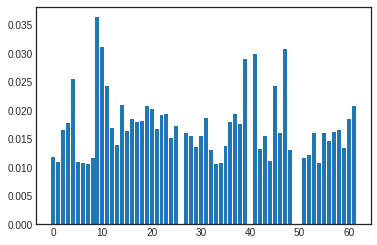

In [ ]:
#displaying the feature importance
import matplotlib.pyplot as plt
print(xgb.feature_importances_)

# plot
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel
from numpy import sort
thresholds = sort(xgb.feature_importances_)
for thresh in thresholds:
 # select features using threshold
 selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
 select_X_train = selection.transform(X_train)
 # train model
 selection_model = XGBClassifier()
 selection_model.fit(select_X_train, y_train)
 # eval model
 select_X_test = selection.transform(X_test)
 predictions = selection_model.predict(select_X_test)
 accuracy = accuracy_score(y_test, predictions)
 print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=62, Accuracy: 78.00%
Thresh=0.000, n=62, Accuracy: 78.00%
Thresh=0.000, n=62, Accuracy: 78.00%
Thresh=0.000, n=62, Accuracy: 78.00%
Thresh=0.010, n=58, Accuracy: 78.00%
Thresh=0.011, n=57, Accuracy: 78.30%
Thresh=0.011, n=56, Accuracy: 78.30%
Thresh=0.011, n=55, Accuracy: 78.30%
Thresh=0.011, n=54, Accuracy: 78.15%
Thresh=0.011, n=53, Accuracy: 78.50%
Thresh=0.011, n=52, Accuracy: 78.30%
Thresh=0.011, n=51, Accuracy: 78.10%
Thresh=0.012, n=50, Accuracy: 78.05%
Thresh=0.012, n=49, Accuracy: 78.15%
Thresh=0.012, n=48, Accuracy: 77.95%
Thresh=0.012, n=47, Accuracy: 77.90%
Thresh=0.013, n=46, Accuracy: 77.75%
Thresh=0.013, n=45, Accuracy: 77.85%
Thresh=0.013, n=44, Accuracy: 77.90%
Thresh=0.013, n=43, Accuracy: 77.90%
Thresh=0.014, n=42, Accuracy: 77.80%
Thresh=0.014, n=41, Accuracy: 77.95%
Thresh=0.014, n=40, Accuracy: 77.75%
Thresh=0.015, n=39, Accuracy: 77.85%
Thresh=0.015, n=38, Accuracy: 77.80%
Thresh=0.016, n=37, Accuracy: 77.90%
Thresh=0.016, n=36, Accuracy: 77.80%
T


<a name="13"></a>

##[Modeling Scores](#13)

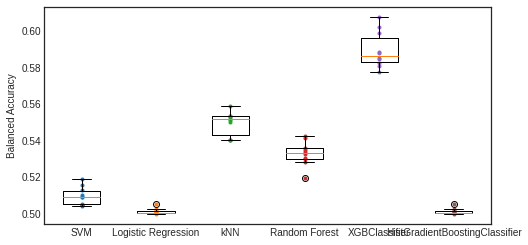

In [ ]:
#scoring all the models and viewing them on a plot
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svc_scores, ".")
plt.plot([2]*10, lr_scores, ".")
plt.plot([3]*10, knn_scores, ".")
plt.plot([4]*10, rf_scores, ".")
plt.plot([5]*10, xgb_scores, ".")
plt.plot([6]*10, bst_scores, ".")

plt.boxplot([svc_scores, lr_scores, knn_scores, rf_scores, xgb_scores, bst_scores], 
            labels=("SVM", "Logistic Regression", "kNN", "Random Forest", "XGBClassifier", "HistGradientBoostingClassifier"))
plt.ylabel("Balanced Accuracy")
plt.show()



<a name="14"></a>

##[Using the XGBClassifier on the Test Set](#14)

In [ ]:
#using the hyperparameters on the test set
xgb = XGBClassifier(n_estimators=100, random_state=42, max_depth=11, n_jobs=11, learning_rate=0.5)
xgb.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(learning_rate=0.5, max_depth=11, n_jobs=11, random_state=42)

In [ ]:
#fitting the model in train and test set
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.753

In [ ]:
y_pred = xgb.predict(X_test)

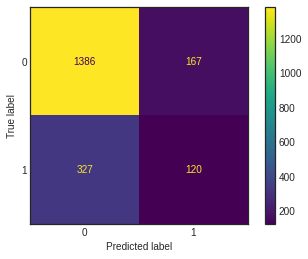

In [ ]:
#displaying the confusion matrix with the testset scores
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

<a name="15"></a>

##[Conclusion](#15)

When we run the XGBClassifier on the testing dataset with the hyperparameters set to the least price, we can see that the model does help us achieve our aim of decreasing false negatives, i.e. estimating non-delays when there are delays at the Chicago O'Hare International Airport. The model was able to decrease false negative counts, which was one our key objective in effectively running the model.